In [1]:
import gym
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import linalg
from copy import deepcopy

In [2]:
def int2onehot(n, max_n):
    res = np.zeros(max_n)
    res[n] = 1.
    return res

In [3]:
red_Din = 160
Din = 128
Dout = 6

In [4]:
lr = 1e-5
training_epochs = 1
D_hid1 = 150
D_hid2 = 60

In [5]:
num_frames = 2
max_steps = 2000
num_games = 100


In [6]:
def dim_reduce(a, V, keep_dim):
    res = np.zeros([keep_dim])
    for i in xrange(keep_dim):
        res[i] = np.matmul(a, V[i])
    return res

In [7]:
def red_train_agent2(training_epochs,red_games, commulative_rewards_np):
    merged_summary = tf.summary.merge_all()
    #writer = tf.summary.FileWriter("/tmp/openai-demon-attack")
    #writer.add_graph(sess.graph)
    
    mx = commulative_rewards_np.max()
    mean = commulative_rewards_np.mean()
    amplitude = commulative_rewards_np.max() - commulative_rewards_np.min()
    step = 1
    for red_game, reward in zip(red_games, commulative_rewards_np):
        #summary = sess.run(merged_summary)
        step += 1
        #writer.add_summary(summary, step)
        actions = np.array([_[1] for _ in red_game])
        observations = np.array([_[0] for _ in red_game])
        l = len(observations)
        #print "Good game"
        #ls = sess.run(red_square_loss, feed_dict={red_x:observations.reshape([l, red_Din]).astype(dtype=np.float32), \
        #        red_y_:actions.reshape([l, Dout]).astype(dtype=np.float32)})
        #print "Nans before: ", sess.run(tf.reduce_sum(tf.is_nan(red_W))), sess.run(tf.reduce_sum(tf.is_nan(red_W1))), \
        #    sess.run(tf.reduce_sum(tf.is_nan(red_b))), sess.run(tf.reduce_sum(tf.is_nan(red_b1)))
        #print "before apply_grads:loss: %f" % ls
        #print "red_W before update: ", sess.run(red_W)
        for n in xrange(training_epochs):
            grads_buff = sess.run(red_grads, feed_dict={red_x:observations.reshape([l, red_Din]).astype(dtype=np.float32),
                                                   red_y_:actions.reshape([l, Dout]).astype(dtype=np.float32)})
            c = (reward - mean) / mean
            sess.run(red_apply_grads, \
                feed_dict={red_grad1_ph:(c * grads_buff[0][0]), \
                                red_grad2_ph:(c * grads_buff[1][0]), \
                               red_grad3_ph:(c * grads_buff[2][0]), \
                               red_grad4_ph:(c * grads_buff[3][0])})
            #print "red_W after update: ", sess.run(red_W)
            #print "Nans after: ", sess.run(tf.reduce_sum(tf.is_nan(red_W))), sess.run(tf.reduce_sum(tf.is_nan(red_W1))), \
            #    sess.run(tf.reduce_sum(tf.is_nan(red_b))), sess.run(tf.reduce_sum(tf.is_nan(red_b1)))
        #print "after apply_grads:loss: %f" % sess.run(red_square_loss, \
        #        feed_dict={red_x:observations.reshape([l, red_Din]).astype(dtype=np.float32), \
        #        red_y_:actions.reshape([l, Dout]).astype(dtype=np.float32)})

In [8]:
def play_random(num_games, max_steps, render):
    games = deque()
    env = gym.make("DemonAttack-ram-v3")
    commulative_rewards = deque()
    for i in xrange(num_games):
        #comp_observation = deque(maxlen = 3)
        observation = np.array(env.reset())
        comp_observation = deepcopy(observation) 
        comp_observations = deque()
        actions = deque()
        current_game = deque()
        commulative_reward = 0
        for j in xrange(max_steps):
            if render:
                env.render()            
            old_observation = observation
            action = env.action_space.sample()
            observation, reward, done, info = env.step(action)
            if len(comp_observation) == num_frames * 128:
                comp_observations.append(deepcopy(comp_observation))
            comp_observation = np.hstack((comp_observation, deepcopy(old_observation)))[-num_frames * 128:]
            commulative_reward += reward
            if(len(comp_observation) == num_frames * 128):
                current_game.append((comp_observation, int2onehot(action, env.action_space.n), reward))
                actions.append(int2onehot(action, env.action_space.n))
                comp_observations.append(comp_observation)
            if done:
                break;
        games.append(current_game)
        commulative_rewards.append(commulative_reward)
    #env.close()
    #del env
    return games, commulative_rewards

In [9]:
def red_play(num_games, max_steps, render, V):
    games = deque()
    actions = [ _ for _ in xrange(0, 6)]
    env = gym.make("DemonAttack-ram-v3")
    commulative_rewards = deque()
    for i in xrange(num_games):
        observation = env.reset()
        comp_observation = deepcopy(observation)
        current_game = deque()
        commulative_reward = 0
        for j in xrange(max_steps):
            if render:
                env.render()
            if len(comp_observation) == num_frames * 128:
                #print "red_play: random_choice(probabilities)", len(comp_observation)
                red_observation = dim_reduce(comp_observation, V, red_Din)
                probabilities = sess.run(red_y, \
                                     feed_dict={red_x:red_observation.reshape([1, \
                                        len(red_observation)]).astype(dtype=np.float32)})
                action = np.random.choice(a=actions, p=probabilities[0])
                observation, reward, done, info = env.step(action)
                current_game.append((red_observation, int2onehot(action, env.action_space.n), reward))
            else:
                #print "red_play: action_space.sample:", len(comp_observation)
                action = env.action_space.sample()
                observation, reward, done, info = env.step(action)
            commulative_reward += reward
            
            comp_observation = np.hstack((comp_observation, observation))[-num_frames * 128:]
            if done:
                break;
        games.append(current_game)
        commulative_rewards.append(commulative_reward)
    #env.close()
    #del env
    return games, commulative_rewards

In [10]:
sess = tf.Session()

Duplicate objects to handle the dimensionality reducted data

In [11]:
red_x = tf.placeholder(tf.float32, [None, red_Din], name="red_x")

red_grad1_ph = tf.placeholder(tf.float32, name="red_grad1_ph")
red_grad2_ph = tf.placeholder(tf.float32, name="red_grad2_ph")
red_grad3_ph = tf.placeholder(tf.float32, name="red_grad3_ph")
red_grad4_ph = tf.placeholder(tf.float32, name="red_grad4_ph")


red_W1 = tf.Variable(tf.random_normal([red_Din, D_hid1], stddev=0.0001), name="red_W1")
red_b1 = tf.Variable(tf.random_normal([D_hid1], stddev=0.0001), name="red_b1") 

red_W = tf.Variable(tf.random_normal([D_hid1, Dout], stddev=0.0001), name="red_W")
red_b = tf.Variable(tf.random_normal([Dout], stddev=0.0001), name="red_b")

red_H = tf.nn.relu(tf.matmul(red_x, red_W1) + red_b1)
red_y = tf.nn.softmax(tf.matmul(red_H, red_W) + red_b)
#red_y = tf.nn.softmax(tf.matmul(red_x, red_W) + red_b, name = "red_y")
red_y_ = tf.placeholder(tf.float32, [None, Dout], name="red_y_")

In [12]:
#red_cross_entropy = tf.reduce_mean(-tf.reduce_sum(red_y_ * tf.log(red_y), reduction_indices=[1]))
red_square_loss = tf.reduce_mean(tf.pow(red_y_ - red_y, 2))

In [13]:
red_adam = tf.train.AdamOptimizer(learning_rate=lr)

#tvars = tf.trainable_variables()
red_tvars = [red_W, red_b, red_W1, red_b1]

red_grads = red_adam.compute_gradients(loss=red_square_loss, var_list=red_tvars)
red_apply_grads = red_adam.apply_gradients(zip([red_grad1_ph, red_grad2_ph, red_grad3_ph, red_grad4_ph],red_tvars))

In [14]:
sess.run(tf.global_variables_initializer())

In [15]:
#play(num_games=1, max_steps=2000, render=True)

In [16]:
games, commulative_rewards = play_random(num_games=num_games, max_steps=2000, render=False)
commulative_rewards_np = np.array(commulative_rewards)

[2017-07-25 09:40:36,779] Making new env: DemonAttack-ram-v3


165.25


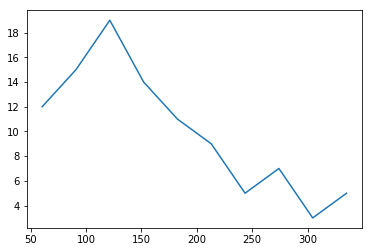

In [17]:
#print games[0], commulative_rewards[0]
rewards_np = np.array( [_ for _ in commulative_rewards], dtype=np.float )
print rewards_np.mean()
h = np.histogram(rewards_np)
plt.plot(h[1][:len(h[1]) - 1] + 10.5, h[0])
plt.show()

In [18]:
game = games[commulative_rewards_np.argmax()]
#print game
commulative_reward = commulative_rewards[commulative_rewards_np.argmax()]
print game[0], commulative_reward
print game[0][0], game[0][1], game[0][2]
#print game
#print sess.run(y, feed_dict={x:game[0][0].reshape([1, len(observation)]).astype(dtype=np.float32)}), game[0][1]

(array([  1, 171,   0, 205,   0, 234,   0,   0,   0,  17,   0,   0,  32,
         0,   0, 216, 216,   0,   0,  73, 152,  27, 200,   1,  42,   0,
         4,   1,  64,   0,   0,   5,   0,   0,   0,   5,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  34,  16,  16, 182,  15,   0,
         1,   0,   0,   0,   0,   0,   0,   3,   0,  62,   1,  51,  40,
        30,  40,  30,  76, 134, 106,  76,   0,   0,   0, 128,   0, 182,
        31,   0,   0, 255,  44,  86,  76, 220,  66,  14,   8,  64,   1,
       192,   0, 100,  31, 110,  31, 120,  31, 130,  31, 140,  31, 128,
        31, 255,   1, 128,   4,   0,   3,   0,   1,   0,   0,   0,   0,
         0,   0, 140,   0, 188,   0,   0,  36,  28, 135,  19,   1, 171,
         0, 205,   0, 234,   0,   0,   0,  17,   0,   0,  32,   0,   0,
       216, 216,   0,   0,  73, 152,  27, 200,   1,  42,   0,   4,   1,
        64,   0,   0,   5,   0,   0,   0,   5,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  34,  16,  16, 182,  15,   0,  

In [19]:
observations = np.array([_[0] for _ in game], dtype=np.float)

In [20]:
print observations
print len(observations[0])

[[   1.  171.    0. ...,   28.  135.   19.]
 [   1.  171.    0. ...,   28.  135.   19.]
 [   0.    0.    0. ...,   28.  135.   19.]
 ..., 
 [   3.    0.    0. ...,   28.   91.   19.]
 [   3.    0.    0. ...,   28.   91.   19.]
 [   3.    0.    0. ...,   28.   91.   19.]]
256


In [21]:
U, s, V = linalg.svd(observations[1:], full_matrices=True, compute_uv=True, overwrite_a=False, check_finite=True, lapack_driver='gesdd')

In [22]:
print s

[  6.26725474e+04   1.08716240e+04   7.84024199e+03   6.83891653e+03
   5.69051104e+03   5.52840105e+03   5.25534850e+03   4.77368146e+03
   4.68536772e+03   4.50405064e+03   4.38591855e+03   4.25796649e+03
   3.85371600e+03   3.75312699e+03   3.59116386e+03   3.48972665e+03
   3.43059632e+03   3.40451484e+03   3.37793370e+03   3.22946736e+03
   3.18858557e+03   3.02268247e+03   2.89157012e+03   2.82574141e+03
   2.76118690e+03   2.70246062e+03   2.68358468e+03   2.65604551e+03
   2.60504880e+03   2.55265792e+03   2.54431866e+03   2.48624602e+03
   2.46942770e+03   2.42943710e+03   2.39737027e+03   2.37367801e+03
   2.30667081e+03   2.29121269e+03   2.24853671e+03   2.17867958e+03
   2.14436815e+03   2.12469720e+03   2.09687491e+03   2.07232440e+03
   2.00195972e+03   1.93984542e+03   1.87160664e+03   1.74699295e+03
   1.64187125e+03   1.62595389e+03   1.60081090e+03   1.48820275e+03
   1.40571509e+03   1.39240661e+03   1.22206411e+03   1.19035116e+03
   1.18841240e+03   1.11301216e+03

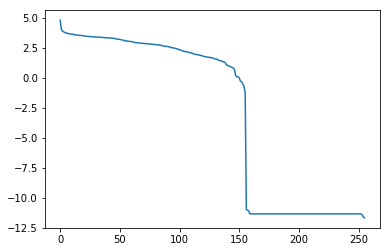

In [23]:
plt.plot(np.log10(s))
plt.show()

In [24]:
#for game in games:
#    for step in game:
#        step = (step, dim_reduce(step[0], V, 50))
#red_games = deque()
#for game in games:
#    red_game = deque()
#    for step in game:
#        red_game.append((dim_reduce(step[0], V, red_Din), step[1], step[2]))
#    red_games.append(red_game)
#dim_reduce(games[0][0][0], V, 50)

In [25]:
#print games[0][0]
#print red_games[0][0]

In [26]:
# red_play(num_games=1, max_steps=5000, render=True, V=V)

In [32]:
#red_games = games
for i in xrange(1):
    red_train_agent2(1, red_games, commulative_rewards_np)

Good game
before apply_grads:loss: 0.138890
after apply_grads:loss: 0.138890
Good game
before apply_grads:loss: 0.138889
after apply_grads:loss: 0.138889
Good game
before apply_grads:loss: 0.138889
after apply_grads:loss: 0.138889
Good game
before apply_grads:loss: 0.138889
after apply_grads:loss: 0.138889
Good game
before apply_grads:loss: 0.138888
after apply_grads:loss: 0.138888
Good game
before apply_grads:loss: 0.138887
after apply_grads:loss: 0.138887
Good game
before apply_grads:loss: 0.138889
after apply_grads:loss: 0.138889
Good game
before apply_grads:loss: 0.138889
after apply_grads:loss: 0.138889
Good game
before apply_grads:loss: 0.138890
after apply_grads:loss: 0.138890
Good game
before apply_grads:loss: 0.138890
after apply_grads:loss: 0.138890
Good game
before apply_grads:loss: 0.138887
after apply_grads:loss: 0.138887
Good game
before apply_grads:loss: 0.138887
after apply_grads:loss: 0.138887
Good game
before apply_grads:loss: 0.138889
after apply_grads:loss: 0.138889

In [39]:
g, r = red_play(num_games=1, max_steps=5000, render=True, V=V)

[2017-07-26 00:47:38,422] Making new env: DemonAttack-ram-v3


[2017-07-18 00:26:26,023] Making new env: DemonAttack-ram-v3


187.0


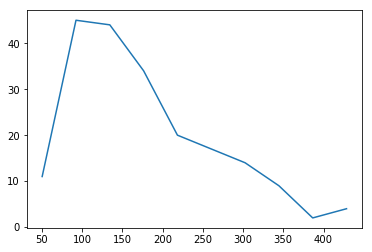

In [34]:
red_games, commulative_rewards = red_play(num_games=num_games, max_steps=5000, render=False, V=V)
rewards_np = np.array( [_ for _ in commulative_rewards], dtype=np.float )
commulative_rewards_np = np.array(commulative_rewards)
print rewards_np.mean()
h = np.histogram(rewards_np)
plt.plot(h[1][:len(h[1]) - 1] + 10.5, h[0])
plt.show()

In [30]:
merged_summary = tf.summary.merge_all()
writer = tf.summary.FileWriter("/tmp/openai-demon-attack")
writer.add_graph(sess.graph)

In [24]:
rewards = np.ndarray([0], dtype=np.float32)

In [ ]:
num_iterations = 5
for i in xrange(num_iterations):
    print "Iteration:", i + 1, '/', num_iterations
    red_games, commulative_rewards = red_play(num_games=num_games, max_steps=3000, render=False, V=V)
    commulative_rewards_np = np.array(commulative_rewards)
    rewards = np.hstack((rewards, commulative_rewards_np))
    x = np.linspace(1, len(rewards), len(rewards))
    plt.plot(x, rewards)
    plt.show()
    red_train_agent2(1, red_games, commulative_rewards_np)

[2017-07-26 00:49:29,381] Making new env: DemonAttack-ram-v3


Iteration: 1 / 5


In [34]:
f = file("rewards-2.dat", "w")
np.save(f, rewards)
f.close()

In [29]:
f = file("V-matrix-2.dat", "w")
np.save(f, V)
f.close()

In [30]:
saver = tf.train.Saver()


In [31]:
saver.save(sess, "OpenAI-DemonAttack-v3-a7-2")

'OpenAI-DemonAttack-v3-a7-2'

In [15]:
f = file("checkpoints/V-matrix.dat")
V = np.load(f)
f.close()

In [16]:
print V

[[ -8.00255011e-04  -3.31441135e-05  -1.38777878e-17 ...,  -1.62339811e-02
   -5.35216361e-02  -1.10056565e-02]
 [ -3.00235492e-03  -4.70215292e-04   4.44089210e-16 ...,  -5.52953555e-03
   -2.90338383e-02  -3.74663468e-03]
 [  1.61260880e-03  -7.41832120e-04   2.22044605e-16 ...,  -3.70738069e-03
   -3.57832713e-02  -2.46822836e-03]
 ..., 
 [  0.00000000e+00   1.08469533e-01   1.65437693e-02 ...,   4.55377354e-02
    9.61036806e-16   1.56675476e-12]
 [ -9.92781685e-01  -2.43358881e-03   2.10638798e-14 ...,  -4.79326293e-04
   -2.00794242e-16  -1.12261518e-13]
 [  0.00000000e+00   9.56605913e-02  -2.18304149e-01 ...,  -1.43543143e-02
   -5.05845366e-15  -4.53214723e-13]]


In [19]:
saver.restore(sess=sess, save_path="/home/martin/notebooks/checkpoints/OpenAI-DemonAttack-v3-a7")